# Load Packages

In [1]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
#import sklearn as sk
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
#from sklearn.preprocessing import Normalizer
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet50
import sys
!pip install rarfile
from rarfile import RarFile
!pip install segmentation-models
import segmentation_models as sm
!pip install git+https://github.com/davej23/image-segmentation-keras.git
from keras_segmentation.models import segnet
from keras.applications import vgg16
from sklearn.metrics import *

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
Segmentation Models: using `keras` framework.
  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-995qg6m_
  Running command git clone -q https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-995qg6m_
     |████████████████████████████████| 2.9MB 4.2MB/s 
     |████████████████████████████████| 3.3MB 27.2MB/s 
     |████████████████████████████████| 952kB 38.9MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp37-none-any.whl size=34374 sha256=640f020fd25ff971892c4e73b65bff63024f83174276c5cdd6191fd27e096925
  Stored in directory: /tmp/pip-ephem-wheel-cache-885c50rw/wheels/ea/b4/05/f1876382a6bfc7c83e9e6b0cd91f785e0820bcb900ec750016
Successfully built keras-segmentation
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: albumentations 0.

In [2]:
# Specify whether to download data or read in
download = True

In [3]:
# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

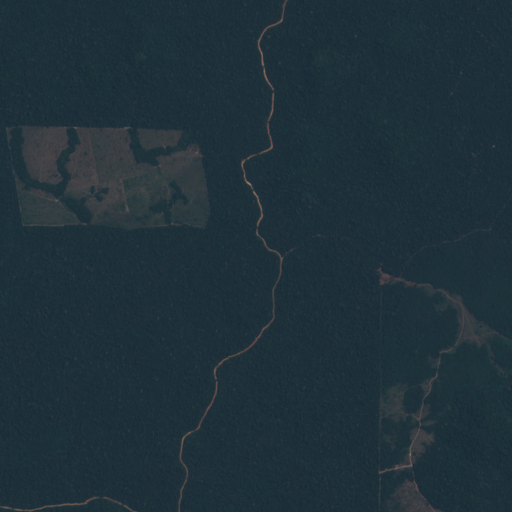

In [4]:
# Example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

# Data Processing

In [5]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [6]:
# Pre-process data
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(1,512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(1,512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

In [7]:
# Augment data
training_images_rot90 = []
training_masks_rot90 = []
validation_images_rot90 = []
validation_masks_rot90 = []

training_images_rot180 = []
training_masks_rot180 = []
validation_images_rot180 = []
validation_masks_rot180 = []

training_images_rot270 = []
training_masks_rot270 = []
validation_images_rot270 = []
validation_masks_rot270 = []

training_images_flip = []
training_masks_flip = []
validation_images_flip = []
validation_masks_flip = []

for i in range(len(training_images)):
  training_images_rot90.append(np.rot90(training_images[i]).reshape(1,512,512,3))
  training_masks_rot90.append(np.rot90(training_masks[i]).reshape(1,512,512,1))
  training_images_rot180.append(np.rot90(training_images[i], k=2).reshape(1,512,512,3))
  training_masks_rot180.append(np.rot90(training_masks[i], k=2).reshape(1,512,512,1))
  training_images_rot270.append(np.rot90(training_images[i], k=3).reshape(1,512,512,3))
  training_masks_rot270.append(np.rot90(training_masks[i], k=3).reshape(1,512,512,1))
  training_images_flip.append(np.flip(training_images[i]).reshape(1,512,512,3))
  training_masks_flip.append(np.flip(training_masks[i]).reshape(1,512,512,1))

for i in range(len(validation_images)):
  validation_images_rot90.append(np.rot90(validation_images[i]).reshape(1,512,512,3))
  validation_masks_rot90.append(np.rot90(validation_masks[i]).reshape(1,512,512,1))
  validation_images_rot180.append(np.rot90(validation_images[i], k=2).reshape(1,512,512,3))
  validation_masks_rot180.append(np.rot90(validation_masks[i], k=2).reshape(1,512,512,1))
  validation_images_rot270.append(np.rot90(validation_images[i], k=3).reshape(1,512,512,3))
  validation_masks_rot270.append(np.rot90(validation_masks[i], k=3).reshape(1,512,512,1))
  validation_images_flip.append(np.flip(validation_images[i]).reshape(1,512,512,3))
  validation_masks_flip.append(np.flip(validation_masks[i]).reshape(1,512,512,1))

'''
training_images_rot90 = np.array(training_images_rot90)
training_masks_rot90 = np.array(training_masks_rot90)
validation_images_rot90 = np.array(validation_images_rot90)
validation_masks_rot90 = np.array(validation_masks_rot90)

training_images_rot180 = np.array(training_images_rot180)
training_masks_rot180 = np.array(training_masks_rot180)
validation_images_rot180 = np.array(validation_images_rot180)
validation_masks_rot180 = np.array(validation_masks_rot180)

training_images_rot270 = np.array(training_images_rot270)
training_masks_rot270 = np.array(training_masks_rot270)
validation_images_rot270 = np.array(validation_images_rot270)
validation_masks_rot270 = np.array(validation_masks_rot270)

training_images_flip = np.array(training_images_flip)
training_masks_flip = np.array(training_masks_flip)
validation_images_flip = np.array(validation_images_flip)
validation_masks_flip = np.array(validation_masks_flip)
'''

'\ntraining_images_rot90 = np.array(training_images_rot90)\ntraining_masks_rot90 = np.array(training_masks_rot90)\nvalidation_images_rot90 = np.array(validation_images_rot90)\nvalidation_masks_rot90 = np.array(validation_masks_rot90)\n\ntraining_images_rot180 = np.array(training_images_rot180)\ntraining_masks_rot180 = np.array(training_masks_rot180)\nvalidation_images_rot180 = np.array(validation_images_rot180)\nvalidation_masks_rot180 = np.array(validation_masks_rot180)\n\ntraining_images_rot270 = np.array(training_images_rot270)\ntraining_masks_rot270 = np.array(training_masks_rot270)\nvalidation_images_rot270 = np.array(validation_images_rot270)\nvalidation_masks_rot270 = np.array(validation_masks_rot270)\n\ntraining_images_flip = np.array(training_images_flip)\ntraining_masks_flip = np.array(training_masks_flip)\nvalidation_images_flip = np.array(validation_images_flip)\nvalidation_masks_flip = np.array(validation_masks_flip)\n'

In [8]:
# Normalise images (if not dividing by 255, this is another method)
'''
normalised_1 = Normalizer().fit(training_images[0][0][:,:,0])
normalised_2 = Normalizer().fit(training_images[0][0][:,:,1])
normalised_3 = Normalizer().fit(training_images[0][0][:,:,2])
normalised_4 = Normalizer().fit(validation_images[0][0][:,:,0])
normalised_5 = Normalizer().fit(validation_images[0][0][:,:,1])
normalised_6 = Normalizer().fit(validation_images[0][0][:,:,2])

training_images[0][0][:,:,0] = normalised_1.transform(training_images[0][0][:,:,0])
training_images[0][0][:,:,1] = normalised_2.transform(training_images[0][0][:,:,1])
training_images[0][0][:,:,2] = normalised_3.transform(training_images[0][0][:,:,2])

validation_images[0][0][:,:,0] = normalised_4.transform(validation_images[0][0][:,:,0])
validation_images[0][0][:,:,1] = normalised_5.transform(validation_images[0][0][:,:,1])
validation_images[0][0][:,:,2] = normalised_6.transform(validation_images[0][0][:,:,2])
'''

'\nnormalised_1 = Normalizer().fit(training_images[0][0][:,:,0])\nnormalised_2 = Normalizer().fit(training_images[0][0][:,:,1])\nnormalised_3 = Normalizer().fit(training_images[0][0][:,:,2])\nnormalised_4 = Normalizer().fit(validation_images[0][0][:,:,0])\nnormalised_5 = Normalizer().fit(validation_images[0][0][:,:,1])\nnormalised_6 = Normalizer().fit(validation_images[0][0][:,:,2])\n\ntraining_images[0][0][:,:,0] = normalised_1.transform(training_images[0][0][:,:,0])\ntraining_images[0][0][:,:,1] = normalised_2.transform(training_images[0][0][:,:,1])\ntraining_images[0][0][:,:,2] = normalised_3.transform(training_images[0][0][:,:,2])\n\nvalidation_images[0][0][:,:,0] = normalised_4.transform(validation_images[0][0][:,:,0])\nvalidation_images[0][0][:,:,1] = normalised_5.transform(validation_images[0][0][:,:,1])\nvalidation_images[0][0][:,:,2] = normalised_6.transform(validation_images[0][0][:,:,2])\n'

In [9]:
# Create new augmented dataset
training_images_augmented = training_images + training_images_rot90 + training_images_rot180 + training_images_rot270 + training_images_flip
training_masks_augmented = training_masks + training_masks_rot90 + training_masks_rot180 + training_masks_rot270 + training_masks_flip
validation_images_augmented = validation_images + validation_images_rot90 + validation_images_rot180 + validation_images_rot270 + validation_images_flip
validation_masks_augmented = validation_masks + validation_masks_rot90 + validation_masks_rot180 + validation_masks_rot270 + validation_masks_flip

In [10]:
# Create TensorFlow datasets for training and validation sets
train_df = tf.data.Dataset.from_tensor_slices((training_images, training_masks))
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [11]:
# Create TensorFlow datasets for training and validation sets (with augmented data)
train_df_augmented = tf.data.Dataset.from_tensor_slices((training_images_augmented, training_masks_augmented))
validation_df_augmented = tf.data.Dataset.from_tensor_slices((validation_images_augmented, validation_masks_augmented))

# Second dataset

https://zenodo.org/record/4498086#.YMh3GfKSmCU

In [12]:
# Download data
download = True # True if files don't already exist in same directory
if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()

base_dir2 = r"./AMAZON/"

In [13]:
!pip install rioxarray
import rioxarray as rxr

     |████████████████████████████████| 51kB 2.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3MB 22.1MB/s 
     |████████████████████████████████| 6.6MB 32.8MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.4.2-cp37-none-any.whl size=51662 sha256=402583fad7ab04444d084001914b33ec3252584d9bed402d48c28d90be29dc22
  Stored in directory: /root/.cache/pip/wheels/cf/61/88/f9f65dd9b52b09577c2f572d72141eecb1f557d833890790f6
Successfully built rioxarray


In [14]:
# Ingest images

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

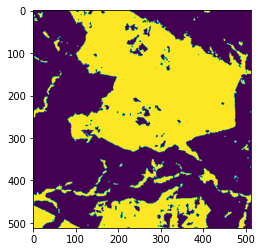

In [15]:
a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,training_masks_list2[20])))[0,:,:])
plt.imshow(a)

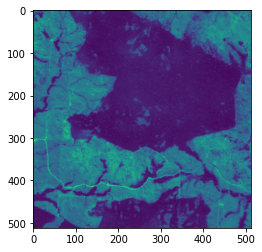

In [16]:
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

(512, 512, 4)


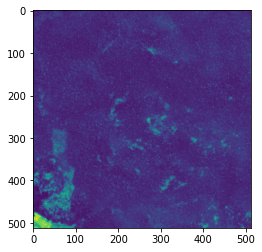

In [17]:
b = training_images2[0].T
print(b.shape)
plt.imshow(b[:,:,0])

(512, 512, 4)


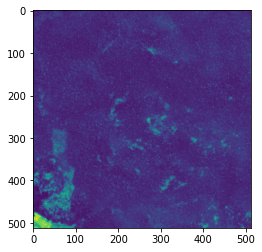

In [18]:
c = b.reshape(1,512,512,4)
d = c.reshape(512,512,4)
print(d.shape)
plt.imshow(d[:,:,0])

(512, 512, 1)


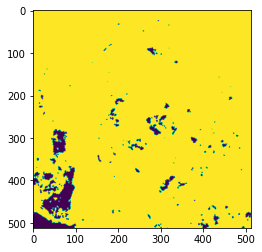

In [19]:
a = training_masks2[0].T
print(a.shape)
plt.imshow(a.reshape(512,512))

In [20]:
# Pre-process data
for i in range(len(training_images2)):
  #training_images2[i] = training_images2[i].reshape(1,512,512,4)
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  #training_masks[i] = training_masks[i][:512,:512]
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  #validation_images2[i] = validation_images2[i].reshape(1,512,512,4)
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  #validation_masks2[i] = validation_masks2[i][:512,:512]
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  #test_images2[i] = test_images2[i].reshape(1,512,512,4)
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  #test_masks2[i] = test_masks2[i][:512,:512]
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T


for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

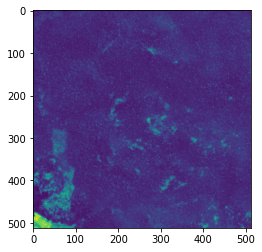

In [21]:
plt.imshow(training_images2[0].reshape(512,512,4)[:,:,0])

In [22]:
# Create TensorFlow datasets for training and validation sets
train_df_large = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_large = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

# U-Net

In [23]:
def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(drop_rate)(pool2)

    #pool2 = BatchNormalization()(drop2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(drop_rate)(pool3)

    #pool3 = BatchNormalization()(drop3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(drop_rate)(pool4) # Adds dropout (for testing)

    #pool4 = BatchNormalization()(drop4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    ## Expansion phase
    up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([drop3,up6])#
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Dropout(drop_rate)(conv6)

    up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])#
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Dropout(drop_rate)(conv7)

    up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])#
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Dropout(drop_rate)(conv8)

    up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])#
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

# Train U-Net with Regular Data

In [ ]:
# Instantiate UNet and train
model = UNet()
save_model = ModelCheckpoint('unet.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model.fit(train_df.repeat(100), validation_data=validation_df, epochs=30, steps_per_epoch=100, shuffle=True, callbacks=[save_model])

Epoch 1/30
  2/100 [..............................] - ETA: 20:38 - loss: 0.7009 - accuracy: 0.5200 - mse: 0.2538

KeyboardInterrupt: 

In [ ]:
# Save model
model.save('unet.h5')

In [ ]:
# Save weights
model.save_weights('weights.h5')

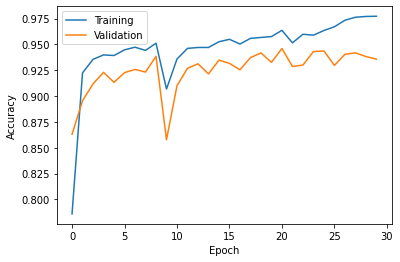

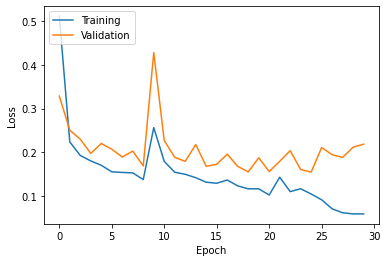

In [ ]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Show model structure
##model.summary()

In [ ]:
# Show picture of model structure
##keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Train U-Net with Augmented Data

In [ ]:
# Instantiate UNet and train using augmented data
model2 = UNet()
save_model2 = ModelCheckpoint('unet-augmented.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model2.fit(train_df_augmented.repeat(20), validation_data=validation_df_augmented, epochs=30, steps_per_epoch=100, shuffle=True, callbacks=[save_model2])

Epoch 1/30
100/100 [==============================] - 36s 337ms/step - loss: 0.5702 - accuracy: 0.7563 - mse: 0.1874 - val_loss: 0.4559 - val_accuracy: 0.8288 - val_mse: 0.1389

Epoch 00001: val_accuracy improved from -inf to 0.82878, saving model to unet--augmented.hdf5
Epoch 2/30
100/100 [==============================] - 33s 327ms/step - loss: 0.4800 - accuracy: 0.7762 - mse: 0.1542 - val_loss: 0.4945 - val_accuracy: 0.8022 - val_mse: 0.1553

Epoch 00002: val_accuracy did not improve from 0.82878
Epoch 3/30
100/100 [==============================] - 32s 325ms/step - loss: 0.2475 - accuracy: 0.9171 - mse: 0.0662 - val_loss: 0.5262 - val_accuracy: 0.7506 - val_mse: 0.1768

Epoch 00003: val_accuracy did not improve from 0.82878
Epoch 4/30
100/100 [==============================] - 32s 324ms/step - loss: 0.3131 - accuracy: 0.9016 - mse: 0.0908 - val_loss: 0.4480 - val_accuracy: 0.8189 - val_mse: 0.1425

Epoch 00004: val_accuracy did not improve from 0.82878
Epoch 5/30
100/100 [=========

# Train U-Net with Large Data

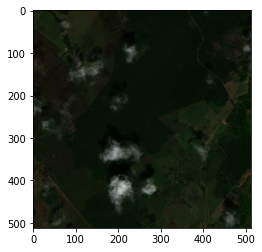

In [31]:
plt.imshow(training_images2[1].reshape(512,512,4)[:,:,0:3])

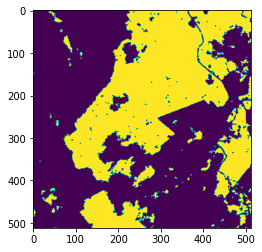

In [32]:
plt.imshow(training_masks2[1].reshape(512,512))

In [39]:
# Instantiate UNet and train using large data
model3 = UNet(input_size=(512,512,4), lr=0.0001)
save_model3 = ModelCheckpoint('unet-large.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model3.fit(train_df_large, validation_data=validation_df_large, epochs=5, shuffle=True, callbacks=[save_model3])

Epoch 1/5
250/250 [==============================] - 245s 968ms/step - loss: 0.4800 - accuracy: 0.7651 - mse: 0.1573 - val_loss: 0.1781 - val_accuracy: 0.9310 - val_mse: 0.0519

Epoch 00001: val_accuracy improved from -inf to 0.93104, saving model to unet-large.hdf5
Epoch 2/5
250/250 [==============================] - 241s 963ms/step - loss: 0.2336 - accuracy: 0.9082 - mse: 0.0684 - val_loss: 0.1400 - val_accuracy: 0.9454 - val_mse: 0.0408

Epoch 00002: val_accuracy improved from 0.93104 to 0.94544, saving model to unet-large.hdf5
Epoch 3/5
250/250 [==============================] - 241s 964ms/step - loss: 0.2002 - accuracy: 0.9213 - mse: 0.0589 - val_loss: 0.1155 - val_accuracy: 0.9536 - val_mse: 0.0340

Epoch 00003: val_accuracy improved from 0.94544 to 0.95362, saving model to unet-large.hdf5
Epoch 4/5
250/250 [==============================] - 241s 964ms/step - loss: 0.1766 - accuracy: 0.9308 - mse: 0.0517 - val_loss: 0.0964 - val_accuracy: 0.9614 - val_mse: 0.0282

Epoch 00004: va

# Functions

In [24]:
def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [25]:
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [ ]:
def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

In [26]:
#
# OLD FUNCTIONS
#
'''
def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    error = np.round(reconstruction).flatten() - (mask).flatten()
    return 1-(np.dot(error, error)/len(error))

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      prediction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
      err = np.round(prediction).flatten() - (mask[i]).flatten()
      scores.append(1-(np.dot(err, err)/len(err)))

    return scores



def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    r = np.round(reconstruction).flatten()
    m = mask.flatten()
    zero_correct = 0
    one_correct = 0
    zero_incorrect = 0
    one_incorrect = 0
    
    for i in range(len(r)):
        if r[i] == m[i]:
            if r[i] == 0:
                zero_correct += 1
            else:
                one_correct += 1
        else:
            if r[i] == 0:
                one_incorrect += 1
            else:
                zero_incorrect += 1

    recall_zero = zero_correct/(zero_correct + one_incorrect)
    recall_one = one_correct/(one_correct + zero_incorrect)
    recall = (recall_one + recall_zero) / 2

    return recall

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        r = np.round(reconstruction).flatten()
        m = mask[i].flatten()

        zero_correct = 0
        one_correct = 0
        zero_incorrect = 0
        one_incorrect = 0
        
        for i in range(len(r)):
            if r[i] == m[i]:
                if r[i] == 0:
                    zero_correct += 1
                else:
                    one_correct += 1
            else:
                if r[i] == 0:
                    one_incorrect += 1
                else:
                    zero_incorrect += 1

        recall_zero = zero_correct/(zero_correct + one_incorrect)
        recall_one = one_correct/(one_correct + zero_incorrect)
        recall.append((recall_one + recall_zero) / 2)

    return recall


def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    r = np.round(reconstruction).flatten()
    m = mask.flatten()
    zero_correct = 0
    one_correct = 0
    zero_incorrect = 0
    one_incorrect = 0
    
    for i in range(len(r)):
        if r[i] == m[i]:
            if r[i] == 0:
                zero_correct += 1
            else:
                one_correct += 1
        else:
            if r[i] == 0:
                one_incorrect += 1
            else:
                zero_incorrect += 1

    precision_zero = zero_correct/(zero_correct + zero_incorrect)
    precision_one = one_correct/(one_correct + one_incorrect)
    precision = (precision_one + precision_zero) / 2

    return precision

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        r = np.round(reconstruction).flatten()
        m = mask[i].flatten()

        zero_correct = 0
        one_correct = 0
        zero_incorrect = 0
        one_incorrect = 0
        
        for i in range(len(r)):
            if r[i] == m[i]:
                if r[i] == 0:
                    zero_correct += 1
                else:
                    one_correct += 1
            else:
                if r[i] == 0:
                    one_incorrect += 1
                else:
                    zero_incorrect += 1

        precision_zero = zero_correct/(zero_correct + zero_incorrect)
        precision_one = one_correct/(one_correct + one_incorrect)
        precision.append((precision_one + precision_zero) / 2)

    return precision


def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))
    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)
    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

'''

# Plot validation image, with mask, and reconstructions

<Figure size 432x288 with 0 Axes>

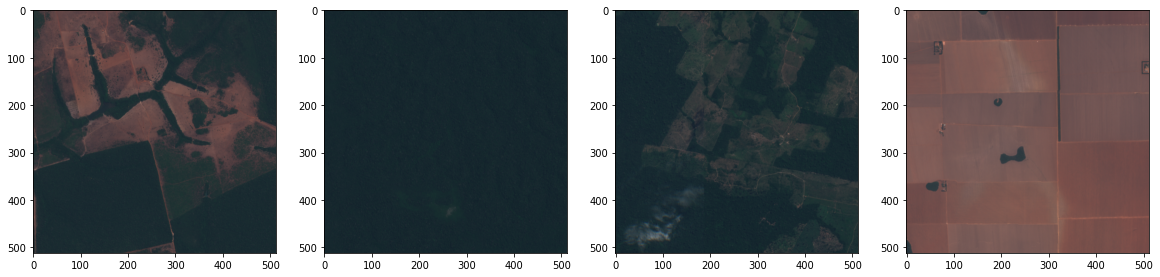

In [ ]:
# Plot a selection of validation set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_images[1].reshape(512,512,3))
ax[1].imshow(validation_images[2].reshape(512,512,3))
ax[2].imshow(validation_images[3].reshape(512,512,3))
ax[3].imshow(validation_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

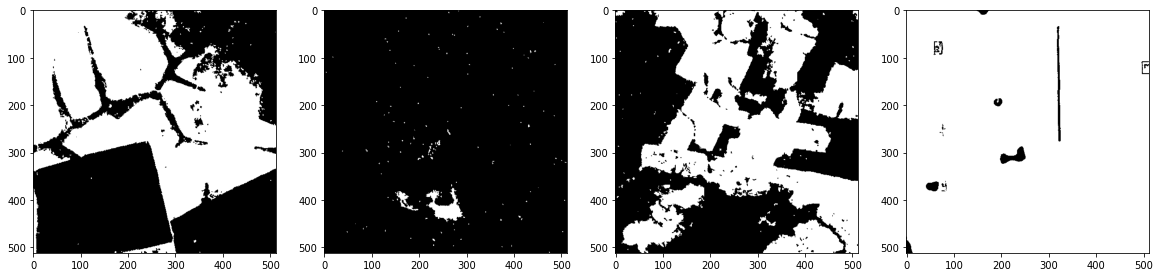

In [ ]:
# Plot corresponding validation set masks
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_masks[1].reshape(512,512), cmap='gray')
ax[1].imshow(validation_masks[2].reshape(512,512), cmap='gray')
ax[2].imshow(validation_masks[3].reshape(512,512), cmap='gray')
ax[3].imshow(validation_masks[4].reshape(512,512), cmap='gray')

<Figure size 432x288 with 0 Axes>

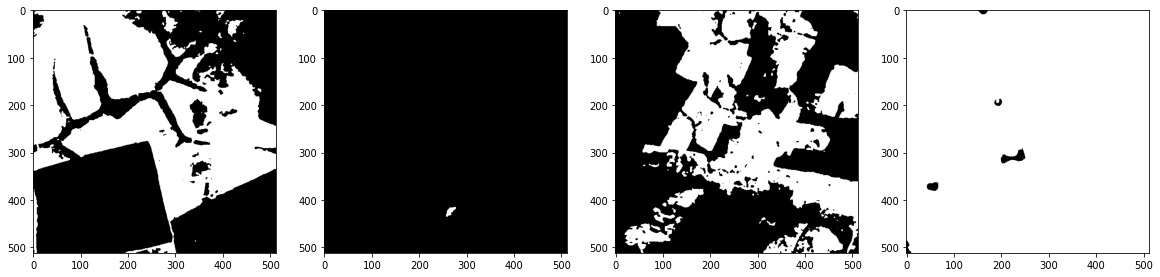

In [ ]:
# Plot reconstructions/predictions of masks for corresponding validation set images (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, validation_images[1], rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model, validation_images[2], rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model, validation_images[3], rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model, validation_images[4], rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

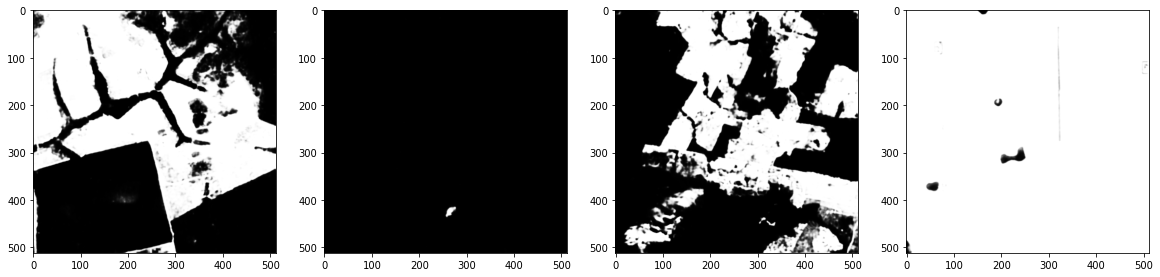

In [ ]:
# Plot reconstructions/predictions of masks for corresponding validation set images (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, validation_images[1], rounded=False), cmap='gray')
ax[1].imshow(reconstruct_array(model, validation_images[2], rounded=False), cmap='gray')
ax[2].imshow(reconstruct_array(model, validation_images[3], rounded=False), cmap='gray')
ax[3].imshow(reconstruct_array(model, validation_images[4], rounded=False), cmap='gray')

# Plot test images and reconstructions

<Figure size 432x288 with 0 Axes>

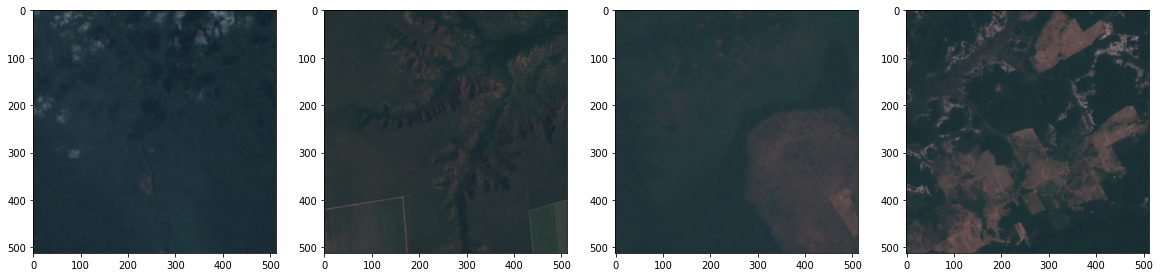

In [ ]:
# Plot a selection of test set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(test_images[1].reshape(512,512,3))
ax[1].imshow(test_images[2].reshape(512,512,3))
ax[2].imshow(test_images[3].reshape(512,512,3))
ax[3].imshow(test_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

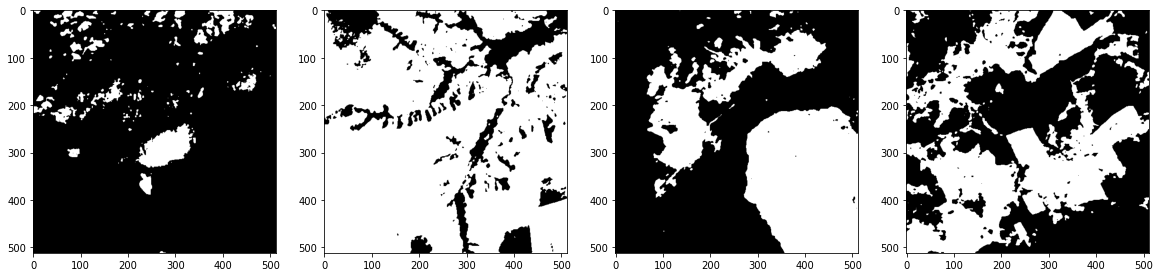

In [ ]:
# Plot corresponding reconstructions/predictions (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, test_images[1], rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model, test_images[2], rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model, test_images[3], rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model, test_images[4], rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

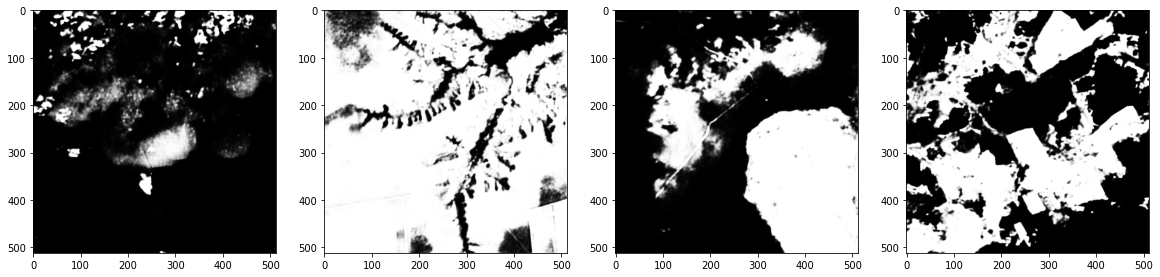

In [ ]:
# Plot corresponding reconstructions/predictions (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, test_images[1]), cmap='gray')
ax[1].imshow(reconstruct_array(model, test_images[2]), cmap='gray')
ax[2].imshow(reconstruct_array(model, test_images[3]), cmap='gray')
ax[3].imshow(reconstruct_array(model, test_images[4]), cmap='gray')

# AMUNet

In [35]:
def attention_gate(input1, input2, nfilters, drop_rate=0.25):

    conv1 = Conv2D(nfilters, kernel_size=1, strides=1, padding="same", kernel_initializer="he_normal")(input1)
    conv1 = Dropout(drop_rate)(conv1)
    conv2 = Conv2D(nfilters, 1, strides=1, padding="same", kernel_initializer="he_normal")(input2)
    conv2 = Dropout(drop_rate)(conv2)
    f = Activation("relu")(add([conv1, conv2]))
    g = Conv2D(filters=1, kernel_size=1, strides=1, padding="same", kernel_initializer="he_normal")(f)
    g = Dropout(drop_rate)(g)
    h = Activation("sigmoid")(g)
    return multiply([input1, h])


def attention_concat(input, skip_connection, drop_rate = 0.25):

    below_filters = input.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, input, below_filters, drop_rate)
    return concatenate([input, attention_across])

In [36]:
def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(drop_rate)(pool2)

    #pool2 = BatchNormalization()(drop2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(drop_rate)(pool3)

    #pool3 = BatchNormalization()(drop3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(drop_rate)(pool4) # Adds dropout (for testing)

    #pool4 = BatchNormalization()(drop4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #drop5 = Dropout(drop_rate)(conv5)

    ## Expansion phase
    up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = attention_concat(up6, conv4, drop_rate) # Attention gate
    #merge6 = BatchNormalization()(merge6)
    #merge6 = concatenate([drop3,up6])#
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Dropout(drop_rate)(conv6)

    up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = attention_concat(up7, conv3, drop_rate) # Attention gate
    #merge7 = BatchNormalization()(merge7)
    #merge7 = concatenate([conv3,up7])#
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Dropout(drop_rate)(conv7)

    up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = attention_concat(up8, conv2, drop_rate) # Attention gate
    #merge8 = BatchNormalization()(merge8)
    #merge8 = concatenate([conv2,up8])#
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Dropout(drop_rate)(conv8)

    up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = attention_concat(up9, conv1, drop_rate) # Attention gate
    #merge9 = concatenate([conv1,up9])#
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

# Train AMUNet with Regular Data

In [ ]:
# Instantiate UNetAM and train with data (repeated)
model_am = UNetAM()
save_model_am = ModelCheckpoint('unet-am.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_am.fit(train_df.repeat(100), validation_data=validation_df, epochs=30, steps_per_epoch=100, shuffle=True, callbacks=[save_model_am])#, validation_data=validation_df)

Epoch 1/30
100/100 [==============================] - 49s 426ms/step - loss: 0.6147 - accuracy: 0.6084 - mse: 0.2139 - val_loss: 0.3334 - val_accuracy: 0.9082 - val_mse: 0.1004

Epoch 00001: val_accuracy improved from -inf to 0.90816, saving model to unet-am.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
100/100 [==============================] - 41s 407ms/step - loss: 0.2910 - accuracy: 0.8927 - mse: 0.0845 - val_loss: 0.2744 - val_accuracy: 0.8890 - val_mse: 0.0825

Epoch 00002: val_accuracy did not improve from 0.90816
Epoch 3/30
100/100 [==============================] - 41s 409ms/step - loss: 0.1870 - accuracy: 0.9347 - mse: 0.0504 - val_loss: 0.2273 - val_accuracy: 0.9149 - val_mse: 0.0652

Epoch 00003: val_accuracy improved from 0.90816 to 0.91494, saving model to unet-am.hdf5
Epoch 4/30
100/100 [==============================] - 41s 411ms/step - loss: 0.1791 - accuracy: 0.9365 - mse: 0.0483 - val_loss: 0.2303 - val_accuracy: 0.9136 - val_mse: 0.0661

Epoch 00004: val_accuracy did not improve from 0.91494
Epoch 5/30
100/100 [==============================] - 41s 410ms/step - loss: 0.1826 - accuracy: 0.9288 - mse: 0.0511 - val_loss: 0.2665 - val_accuracy: 0.9032 - val_mse: 0.0752

Epoch 00005: val_accuracy did not improve from 0.91494
Epoch 6/30
100/100 [==============

# Train AMUNet with Augmented Data

In [ ]:
# Instantiate UNetAM and train with augmented data
model_am_augmented = UNetAM()
save_model_am_aug = ModelCheckpoint('unet-am-augmented.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_am_augmented.fit(train_df_augmented.repeat(20), validation_data=validation_df, epochs=30, steps_per_epoch=100, shuffle=True, callbacks=[save_model_am_aug])#, validation_data=validation_df)

Epoch 1/30
100/100 [==============================] - 46s 423ms/step - loss: 0.5868 - accuracy: 0.6425 - mse: 0.2021 - val_loss: 0.4536 - val_accuracy: 0.8347 - val_mse: 0.1271

Epoch 00001: val_accuracy improved from -inf to 0.83472, saving model to unet-am-augmented.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
100/100 [==============================] - 40s 405ms/step - loss: 0.4912 - accuracy: 0.7581 - mse: 0.1509 - val_loss: 0.2892 - val_accuracy: 0.8814 - val_mse: 0.0887

Epoch 00002: val_accuracy improved from 0.83472 to 0.88143, saving model to unet-am-augmented.hdf5
Epoch 3/30
100/100 [==============================] - 40s 404ms/step - loss: 0.2727 - accuracy: 0.9046 - mse: 0.0770 - val_loss: 0.6923 - val_accuracy: 0.5687 - val_mse: 0.2493

Epoch 00003: val_accuracy did not improve from 0.88143
Epoch 4/30
100/100 [==============================] - 40s 404ms/step - loss: 0.3584 - accuracy: 0.8742 - mse: 0.1091 - val_loss: 0.2433 - val_accuracy: 0.9015 - val_mse: 0.0732

Epoch 00004: val_accuracy improved from 0.88143 to 0.90154, saving model to unet-am-augmented.hdf5
Epoch 5/30
100/100 [==============================] - 40s 404ms/step - loss: 0.3642 - accuracy: 0.8051 - mse: 0.1203 - val_loss: 0.3636 - val_accuracy: 0.8645 - val_mse: 0.1054

Epoch 00005: val_accuracy did not i

# Train AMUNet with Large Data

In [40]:
# Instantiate UNetAM and train with large data
model_am_large = UNetAM(input_size = (512,512,4))
save_model_am_large = ModelCheckpoint('unet-am-large.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
model_am_large.fit(train_df_large, validation_data=validation_df_large, epochs=5, shuffle=True, callbacks=[save_model_am_large])#, validation_data=validation_df)

Epoch 1/5
250/250 [==============================] - 322s 1s/step - loss: 0.5549 - accuracy: 0.7537 - mse: 0.1814 - val_loss: 0.2037 - val_accuracy: 0.9236 - val_mse: 0.0587

Epoch 00001: val_accuracy improved from -inf to 0.92362, saving model to unet-am-large.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
250/250 [==============================] - 314s 1s/step - loss: 0.2505 - accuracy: 0.9051 - mse: 0.0729 - val_loss: 0.1576 - val_accuracy: 0.9400 - val_mse: 0.0455

Epoch 00002: val_accuracy improved from 0.92362 to 0.93997, saving model to unet-am-large.hdf5
Epoch 3/5
250/250 [==============================] - 316s 1s/step - loss: 0.2168 - accuracy: 0.9179 - mse: 0.0629 - val_loss: 0.1338 - val_accuracy: 0.9486 - val_mse: 0.0386

Epoch 00003: val_accuracy improved from 0.93997 to 0.94862, saving model to unet-am-large.hdf5
Epoch 4/5
250/250 [==============================] - 315s 1s/step - loss: 0.1904 - accuracy: 0.9253 - mse: 0.0559 - val_loss: 0.1094 - val_accuracy: 0.9574 - val_mse: 0.0317

Epoch 00004: val_accuracy improved from 0.94862 to 0.95741, saving model to unet-am-large.hdf5
Epoch 5/5
250/250 [==============================] - 314s 1s/step - loss: 0.1672 - accuracy: 0.9353 - mse: 0.0485 - val_loss: 0.0952 - val_accuracy: 0.9628 - val_mse: 0.0276

Epoch 00005: va

# ResNet

**Links to review**

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

https://github.com/divamgupta/image-segmentation-keras

https://arxiv.org/pdf/1511.00561.pdf

https://segmentation-models.readthedocs.io/en/latest/tutorial.html

https://github.com/qubvel/classification_models/blob/master/classification_models/models/resnet.py   -- ResNet50 encoder

https://github.com/preddy5/segnet/blob/master/segnet.py -- SegNet

https://github.com/divamgupta/image-segmentation-keras -- Forked code from here for below

https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwivq5G4jJ3xAhVI4aQKHWy5BtwQFjAKegQIAxAE&url=https%3A%2F%2Fwww.mdpi.com%2F2072-4292%2F12%2F16%2F2602%2Fpdf&usg=AOvVaw3AOQ4oRuhqtryRZWAvriNV

In [ ]:
R = segnet.resnet50_segnet(1, 512, 512)
R.compile(optimizer = Adam(learning_rate = 0.00001), loss='binary_crossentropy', metrics = ['accuracy', 'mse'])
R.fit(train_df.repeat(200), validation_data = validation_df, epochs=60, steps_per_epoch = 100, shuffle = True)

Epoch 1/60
100/100 [==============================] - 23s 129ms/step - loss: 0.7602 - accuracy: 0.6511 - mse: 0.2440 - val_loss: 1.0930 - val_accuracy: 0.4856 - val_mse: 0.3142
Epoch 2/60
100/100 [==============================] - 10s 98ms/step - loss: 0.4828 - accuracy: 0.7750 - mse: 0.1563 - val_loss: 1.3975 - val_accuracy: 0.4781 - val_mse: 0.3837
Epoch 3/60
100/100 [==============================] - 10s 99ms/step - loss: 0.3858 - accuracy: 0.8376 - mse: 0.1189 - val_loss: 1.4950 - val_accuracy: 0.4659 - val_mse: 0.3673
Epoch 4/60
100/100 [==============================] - 10s 100ms/step - loss: 0.3687 - accuracy: 0.8489 - mse: 0.1111 - val_loss: 1.8859 - val_accuracy: 0.4804 - val_mse: 0.3640
Epoch 5/60
100/100 [==============================] - 10s 99ms/step - loss: 0.3245 - accuracy: 0.8708 - mse: 0.0948 - val_loss: 2.3677 - val_accuracy: 0.4516 - val_mse: 0.4552
Epoch 6/60
100/100 [==============================] - 10s 99ms/step - loss: 0.2796 - accuracy: 0.9006 - mse: 0.0776 - 

In [ ]:
def ResNet50SegNet(input_shape=(512,512,3), weights = None, initial_filters=32):
  # ResNet Encoder
  def handle_block_names(stage, block):
      name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
      conv_name = name_base + 'conv'
      bn_name = name_base + 'bn'
      relu_name = name_base + 'relu'
      sc_name = name_base + 'sc'
      return conv_name, bn_name, relu_name, sc_name


  def get_conv_params(**params):
      default_conv_params = {
          'kernel_initializer': 'he_uniform',
          'use_bias': False,
          'padding': 'valid',
      }
      default_conv_params.update(params)
      return default_conv_params


  def get_bn_params(**params):
      axis = 3 if backend.image_data_format() == 'channels_last' else 1
      default_bn_params = {
          'axis': axis,
          'momentum': 0.99,
          'epsilon': 2e-5,
          'center': True,
          'scale': True,
      }
      default_bn_params.update(params)
      return default_bn_params
  def residual_conv_block(filters, stage, block, strides=(1, 1), attention=None, cut='pre'):
      """The identity block is the block that has no conv layer at shortcut.
      # Arguments
          input_tensor: input tensor
          kernel_size: default 3, the kernel size of
              middle conv layer at main path
          filters: list of integers, the filters of 3 conv layer at main path
          stage: integer, current stage label, used for generating layer names
          block: 'a','b'..., current block label, used for generating layer names
          cut: one of 'pre', 'post'. used to decide where skip connection is taken
      # Returns
          Output tensor for the block.
      """

      def layer(input_tensor):

          # get params and names of layers
          conv_params = get_conv_params()
          bn_params = get_bn_params()
          conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

          x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
          x = Activation('relu', name=relu_name + '1')(x)

          # defining shortcut connection
          if cut == 'pre':
              shortcut = input_tensor
          elif cut == 'post':
              shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(x)
          else:
              raise ValueError('Cut type not in ["pre", "post"]')

          # continue with convolution layers
          x = ZeroPadding2D(padding=(1, 1))(x)
          x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

          x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
          x = Activation('relu', name=relu_name + '2')(x)
          x = ZeroPadding2D(padding=(1, 1))(x)
          x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

          # add residual connection
          x = Add()([x, shortcut])
          return x

      return layer


  def residual_bottleneck_block(filters, stage, block, strides=None, attention=None, cut='pre'):
      """The identity block is the block that has no conv layer at shortcut.
      # Arguments
          input_tensor: input tensor
          kernel_size: default 3, the kernel size of
              middle conv layer at main path
          filters: list of integers, the filters of 3 conv layer at main path
          stage: integer, current stage label, used for generating layer names
          block: 'a','b'..., current block label, used for generating layer names
          cut: one of 'pre', 'post'. used to decide where skip connection is taken
      # Returns
          Output tensor for the block.
      """

      def layer(input_tensor):

          # get params and names of layers
          conv_params = get_conv_params()
          bn_params = get_bn_params()
          conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

          x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
          x = Activation('relu', name=relu_name + '1')(x)

          # defining shortcut connection
          if cut == 'pre':
              shortcut = input_tensor
          elif cut == 'post':
              shortcut = Conv2D(filters * 4, (1, 1), name=sc_name, strides=strides, **conv_params)(x)
          else:
              raise ValueError('Cut type not in ["pre", "post"]')

          # continue with convolution layers
          x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

          x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
          x = Activation('relu', name=relu_name + '2')(x)
          x = ZeroPadding2D(padding=(1, 1))(x)
          x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

          x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
          x = Activation('relu', name=relu_name + '3')(x)
          x = Conv2D(filters * 4, (1, 1), name=conv_name + '3', **conv_params)(x)

          # add residual connection
          x = Add()([x, shortcut])

          return x

      return layer

  # Encoding
  inputs = Input(input_shape)
  x = BatchNormalization()(inputs)
  x = ZeroPadding2D(padding=(3, 3))(x)
  x = Conv2D(initial_filters, (7, 7), strides=(2, 2), name='conv0')(x)
  x = BatchNormalization(name='bn0')(x)
  x = Activation('relu', name='relu0')(x)
  x = ZeroPadding2D(padding=(1, 1))(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)

  # Residual Blocks
  for stage, rep in enumerate((3,4,6,3)):
      for block in range(rep):

          filters = initial_filters * (2 ** stage)

          # first block of first stage without strides because we have maxpooling before
          if block == 0 and stage == 0:
              x = residual_bottleneck_block(filters, stage, block, strides=(1, 1),
                                cut='post', attention=Attention)(x)

          elif block == 0:
              x = residual_bottleneck_block(filters, stage, block, strides=(2, 2),
                                cut='post', attention=Attention)(x)

          else:
              x = residual_bottleneck_block(filters, stage, block, strides=(1, 1),
                                cut='pre', attention=Attention)(x)

  x = BatchNormalization(name='bn1')(x)
  x = Activation('sigmoid', name='relu1')(x)

  # SegNet Decoder
  x = UpSampling2D(size=(2,2))(x)
  #x = ZeroPadding2D(padding=(1,1))(x)
  x = Convolution2D(32, 1, padding='valid')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(size=(2,2))(x)
  #x = ZeroPadding2D(padding=(1,1))(x)
  x = Convolution2D(64, 1, padding='valid')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(size=(2,2))(x)
  #x = ZeroPadding2D(padding=(1,1))(x)
  x = Convolution2D(128, 1, padding='valid')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(size=(2,2))(x)
  #x = ZeroPadding2D(padding=(1,1))(x)
  x = Convolution2D(128, 1, padding='valid')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(size=(2,2))(x)
  #x = ZeroPadding2D(padding=(1,1))(x)
  x = Convolution2D(128, 1, padding='valid')(x)
  x = BatchNormalization()(x)

  x = Convolution2D(1, 1, padding='valid')(x)
  x = Reshape((512,512,1))(x)
  output = Activation('sigmoid')(x)

  model = Model(inputs, output)
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

  return model


In [ ]:
R = ResNet50SegNet()
R.fit(train_df.repeat(200), validation_data = validation_df, epochs=30, steps_per_epoch = 100, shuffle=True)

Epoch 1/30
100/100 [==============================] - 25s 126ms/step - loss: 0.6788 - accuracy: 0.6161 - mse: 0.2383 - val_loss: 0.7532 - val_accuracy: 0.5222 - val_mse: 0.2775
Epoch 2/30
100/100 [==============================] - 9s 85ms/step - loss: 0.5436 - accuracy: 0.7356 - mse: 0.1815 - val_loss: 0.7404 - val_accuracy: 0.5222 - val_mse: 0.2719
Epoch 3/30
100/100 [==============================] - 9s 86ms/step - loss: 0.4786 - accuracy: 0.7982 - mse: 0.1530 - val_loss: 0.9396 - val_accuracy: 0.5222 - val_mse: 0.3406
Epoch 4/30
100/100 [==============================] - 9s 87ms/step - loss: 0.4799 - accuracy: 0.7979 - mse: 0.1519 - val_loss: 0.8093 - val_accuracy: 0.5227 - val_mse: 0.2983
Epoch 5/30
100/100 [==============================] - 9s 86ms/step - loss: 0.4859 - accuracy: 0.7870 - mse: 0.1548 - val_loss: 0.6010 - val_accuracy: 0.6911 - val_mse: 0.2073
Epoch 6/30
100/100 [==============================] - 9s 85ms/step - loss: 0.4334 - accuracy: 0.8293 - mse: 0.1336 - val_lo

In [ ]:
resnet = sm.Unet('resnet50', encoder_weights=None, input_shape=(512,512,3), classes=1, activation='sigmoid', decoder_use_batchnorm=True)
resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = ['accuracy', 'mse'])

In [ ]:
resnet.fit(train_df.repeat(200), validation_data=validation_df, epochs=30, steps_per_epoch=100, shuffle=True)

Epoch 1/30
100/100 [==============================] - 58s 420ms/step - loss: 0.5713 - accuracy: 0.6945 - mse: 0.1943 - val_loss: 0.7103 - val_accuracy: 0.5222 - val_mse: 0.2600
Epoch 2/30
100/100 [==============================] - 36s 361ms/step - loss: 0.3593 - accuracy: 0.8715 - mse: 0.1078 - val_loss: 0.7381 - val_accuracy: 0.5261 - val_mse: 0.2724
Epoch 3/30
100/100 [==============================] - 36s 361ms/step - loss: 0.2997 - accuracy: 0.9117 - mse: 0.0843 - val_loss: 0.6309 - val_accuracy: 0.5385 - val_mse: 0.2232
Epoch 4/30
100/100 [==============================] - 36s 360ms/step - loss: 0.2556 - accuracy: 0.9394 - mse: 0.0670 - val_loss: 0.6691 - val_accuracy: 0.5469 - val_mse: 0.2424
Epoch 5/30
100/100 [==============================] - 36s 361ms/step - loss: 0.1966 - accuracy: 0.9559 - mse: 0.0476 - val_loss: 0.4712 - val_accuracy: 0.7458 - val_mse: 0.1566
Epoch 6/30
100/100 [==============================] - 36s 361ms/step - loss: 0.1685 - accuracy: 0.9648 - mse: 0.038

# FCN

https://github.com/divamgupta/image-segmentation-keras - Forked code from here for below

In [ ]:
IMAGE_ORDERING = 'channels_last'
from types import MethodType

def get_segmentation_model(input, output):

    img_input = input
    o = output

    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        #o = (Reshape((output_height*output_width, -1)))(o)
        o = Convolution2D(kernel_size=1, filters=1)(o)

    o = (Activation('sigmoid'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""

    #model.train = MethodType(train, model)
    #model.predict_segmentation = MethodType(predict, model)
    #model.predict_multiple = MethodType(predict_multiple, model)
    #model.evaluate_segmentation = MethodType(evaluate, model)

    return model

def vanilla_encoder(input_height=512,  input_width=512, channels=3):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    x = img_input
    levels = []

    #x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
    x = (Conv2D(filter_size, (kernel, kernel),
                data_format=IMAGE_ORDERING, padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format=IMAGE_ORDERING))(x)
    levels.append(x)

    x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
    x = (Conv2D(128, (kernel, kernel), data_format=IMAGE_ORDERING,
         padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format=IMAGE_ORDERING))(x)
    levels.append(x)

    for _ in range(3):
        x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
        x = (Conv2D(256, (kernel, kernel),
                    data_format=IMAGE_ORDERING, padding='valid'))(x)
        x = (BatchNormalization())(x)
        x = (Activation('relu'))(x)
        x = (MaxPooling2D((pool_size, pool_size),
             data_format=IMAGE_ORDERING))(x)
        levels.append(x)

    return img_input, levels

def fcn_32(n_classes, encoder=vanilla_encoder, input_height=512,
           input_width=512, channels=3):

    img_input, levels = encoder(
        input_height=input_height,  input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    o = (Conv2D(4096, (7, 7), activation='relu',
                padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)
    o = (Conv2D(4096, (1, 1), activation='relu',
                padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    o = (Conv2D(n_classes,  (1, 1), kernel_initializer='he_normal',
                data_format=IMAGE_ORDERING , name="seg_feats" ))(o)
    o = Conv2DTranspose(n_classes, kernel_size=(64, 64),  strides=(
        32, 32), use_bias=False,  data_format=IMAGE_ORDERING)(o)

    model = get_segmentation_model(img_input, o)
    model.model_name = "fcn_32"
    return model

In [ ]:
F = fcn_32(1, input_height=512, input_width=512)
F.compile(optimizer = Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics = ['accuracy', 'mse'])
F.fit(train_df.repeat(100), validation_data = validation_df, epochs=30, steps_per_epoch = 100, shuffle = True)

Epoch 1/30
100/100 [==============================] - 20s 179ms/step - loss: 0.6934 - accuracy: 0.5025 - mse: 0.2501 - val_loss: 0.6932 - val_accuracy: 0.4946 - val_mse: 0.2500
Epoch 2/30
100/100 [==============================] - 17s 171ms/step - loss: 0.6882 - accuracy: 0.5411 - mse: 0.2473 - val_loss: 0.6912 - val_accuracy: 0.5237 - val_mse: 0.2491
Epoch 3/30
100/100 [==============================] - 17s 172ms/step - loss: 0.5915 - accuracy: 0.7170 - mse: 0.2003 - val_loss: 0.9345 - val_accuracy: 0.5229 - val_mse: 0.3326
Epoch 4/30
100/100 [==============================] - 17s 172ms/step - loss: 0.4194 - accuracy: 0.8204 - mse: 0.1335 - val_loss: 1.8510 - val_accuracy: 0.5223 - val_mse: 0.4299
Epoch 5/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3418 - accuracy: 0.8548 - mse: 0.1069 - val_loss: 2.9009 - val_accuracy: 0.5222 - val_mse: 0.4551
Epoch 6/30
100/100 [==============================] - 17s 174ms/step - loss: 0.2703 - accuracy: 0.8846 - mse: 0.083

# Test Results

In [ ]:
# Find final accuracy on validation set using model trained with augmented data
validation_scores_unet_aug = score_eval(model2, validation_images, validation_masks)
print(np.mean(validation_scores_unet_aug))

# Find final accuracy on validation set using model trained with normal data (repeated)
validation_scores_unet = score_eval(model, validation_images, validation_masks)
print(np.mean(validation_scores_unet))

0.9224075317382813
0.9357343037923177


In [ ]:
# Using AM model
# Trained with normal data (repeated)
validation_scores_am = score_eval(model_am, validation_images, validation_masks)
print(np.mean(validation_scores_am))

# Trained with normal data (repeated)
validation_scores_am_aug = score_eval(model_am_augmented, validation_images, validation_masks)
print(np.mean(validation_scores_am_aug))

0.9394554138183594
0.927843983968099


# Import Models

In [ ]:
am_unet = load_model('./Models/unet-am-regular-data.hdf5')
am_unet_1 = load_model('./Models/unet-am-augmented-data.hdf5')
unet = load_model('./Models/unet-regular-data.hdf5')
unet_1 = load_model('./Models/unet-augmented-data.hdf5')
unet_large = load_model('./Models/unet-large.hdf5')

OSError: ignored

In [ ]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
unet1_score = (score_eval(unet_1, validation_images, validation_masks))
am_unet_score = (score_eval(am_unet, validation_images, validation_masks))
am_unet1_score = (score_eval(am_unet_1, validation_images, validation_masks))

In [ ]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
unet1_precision = (precision_eval(unet_1, validation_images, validation_masks))
am_unet_precision = (precision_eval(am_unet, validation_images, validation_masks))
am_unet1_precision = (precision_eval(am_unet_1, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
unet1_recall = (recall_eval(unet_1, validation_images, validation_masks))
am_unet_recall = (recall_eval(am_unet, validation_images, validation_masks))
am_unet1_recall = (recall_eval(am_unet_1, validation_images, validation_masks))

In [ ]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
unet1_f1_score = (f1_score_eval_basic(unet1_precision, unet1_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))
am_unet1_f1_score = (f1_score_eval_basic(am_unet1_precision, am_unet1_recall))

In [ ]:
# Print score eval results for each model
print(np.mean(unet_score))
print(np.mean(unet1_score))
print(np.mean(am_unet_score))
print(np.mean(am_unet1_score))

0.946020762125651
0.947503662109375
0.9454429626464844
0.9480356852213542


In [ ]:
# Print precision eval results for each model
print(np.mean(unet_precision))
print(np.mean(unet1_precision))
print(np.mean(am_unet_precision))
print(np.mean(am_unet1_precision))

0.8775880581600012
0.885042372034699
0.8782023487007723
0.8834499578373708


In [ ]:
# Print recall eval results for each model
print(np.mean(unet_recall))
print(np.mean(unet1_recall))
print(np.mean(am_unet_recall))
print(np.mean(am_unet1_recall))

0.9460374510924521
0.9432597963514906
0.9464476505286775
0.9433290932762713


In [ ]:
# Print f1-score eval results for each model
print(np.mean(unet_f1_score))
print(np.mean(unet1_f1_score))
print(np.mean(am_unet_f1_score))
print(np.mean(am_unet1_f1_score))

0.9105281379741098
0.9132241946032101
0.9110487490396698
0.9124081504806387
